In [96]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy import constants
from ipywidgets import interact
import matplotlib.gridspec as gridspec

In [43]:
# To save some typing
pi = np.pi
hbar = constants.hbar
# Better defauls
plt.rcParams['figure.dpi'] = 100

Plotting routines (collapsed cell):

In [172]:
# Let's make a function to make these plots on demand

def plot_cavity():
    plt.figure(figsize=(12,3.5))
    G = gridspec.GridSpec(1, 3)
    plt.subplot(G[0,:-1])
    plt.plot(t*1e6,np.real(a), label="Real")
    plt.plot(t*1e6,np.imag(a), label="Imag")
    plt.plot(t*1e6,np.abs(a), label="")
    plt.axhline(0,ls=":", c="grey")
    plt.legend()
    plt.ylabel("Cavity field amplitude $a$");
    plt.xlabel("Time ($\mu$s)")
    plt.subplot(G[0,2])
    m = np.max(np.abs(a))*1.2
    plt.plot(np.real(a), np.imag(a))
    plt.xlim((-m,m))
    plt.ylim((-m,m))
    plt.axhline(0,ls=":", c="grey")
    plt.axvline(0,ls=":", c="grey")
    plt.tight_layout()


def plot_both():
    plot_cavity()
    plt.figure(figsize=(12,4)) 
    G = gridspec.GridSpec(1, 3)
    plt.subplot(G[0,:-1])    
    plt.plot(t*1e6,np.real(x), label="x")
    plt.axhline(0,ls=":", c="grey")
    plt.legend()
    plt.ylabel("Mechanical displacement $x$");
    plt.xlabel("Time ($\mu$s)");

# The full nonlinear equations and integrator

Our equations of motion for optomechanics.

First start with the mechanics:

$$
\frac{dv}{dt} = \frac{F}{m} = -\gamma v + \frac{\hbar G |a|^2}{m}
$$

where the variable $a$ is the (classical) complex field variable (<a href=https://nas-steelelab.tnw.tudelft.nl:5001/d/f/481363702669389679>Haus</a> page 198): for an LC circuit, if $i$ is the current in the inductor and $v$ is the voltage on the capacitor, then $a$ is given by:

$$
a = \sqrt{\frac{C}{2}} \left( v + j \sqrt{\frac{L}{C}} i \right)
$$

where $j = \sqrt{-1}$. In this convention, a would have funny units: it would have units of the square root of Energy, or equivalently, the square root of photon number. In the equations we will use, we will divide this by $\hbar \omega_c$ to convert these into photon number. 

Doing so, the equation of motion for the cavity is reduced from a second order (real valued) one to a first order (complex-valued) one. We will furthermore go into the rotating frame of the the external drive tone by including a factor $\exp(i\omega_d t)$ in $a$ already. This gives the following equation of motion for $a$: 

$$
\frac{da}{dt} = j(\Delta + Gx) a - \frac{\kappa a}{2}
$$

To include an external driving of the cavity, we need to add additional terms to this equation: 

$$
\frac{da}{dt} = j(\Delta + Gx) a - \frac{\kappa a}{2} + \kappa_{e} a_{e} \exp(-j \omega_{e} t)
$$

For OMIT, our driving will consist of two terms: a pump term and a probe term. For the measurement analysis, it is easiest to go into the rotating frame of the probe, since our network analyzer will measure at the probe frequency. In this case, $\Delta$ in the equation above is then detuning of the probe frequency from the cavity resonance frequency. 


## The integrator

In [175]:
def dydt(t, y):
    v = y[0]
    x = y[1]
    a = y[2]
    
    dy0 = -gamma*v - (w_m**2)*x + hbar*G*np.abs(a)**2/m
    dy1 = v
    dy2 = 1j*(delta + G*x)*a - kappa/2.0*a + np.sqrt(kext)* \
            (np.sqrt(probe)*np.exp(1j*w_probe*t) \
            + np.sqrt(pump)*np.exp(1j*w_pump*t))
    
    return np.array([dy0, dy1, dy2])

Parameters:

* `delta`: Detuning of the cavity resonance relative to the rotating frame
* `probe`, `w_probe`: Probe power and probe angular frequency, relative to rotating frame frequency
* `pump`, `w_pump`: Pump power and probe angular frequency, relative to rotating frame frequency
* `w_m`, `gamma`: Mechanical angular frequency, mechanical damping rate
* `m`: Mass of mechanical resonator
* `G`: Cavity pull parameter (dw/dx)

Variables:

* `a`: (Complex-valued) Cavity field variable
* `x`, `v`: mechanical displacement and velocity

# Testing and benchmarking

## Simple example: `g_0 = 0`, `delta = 0`, ring up cavity

x_zpf is 1.827314e-16 m


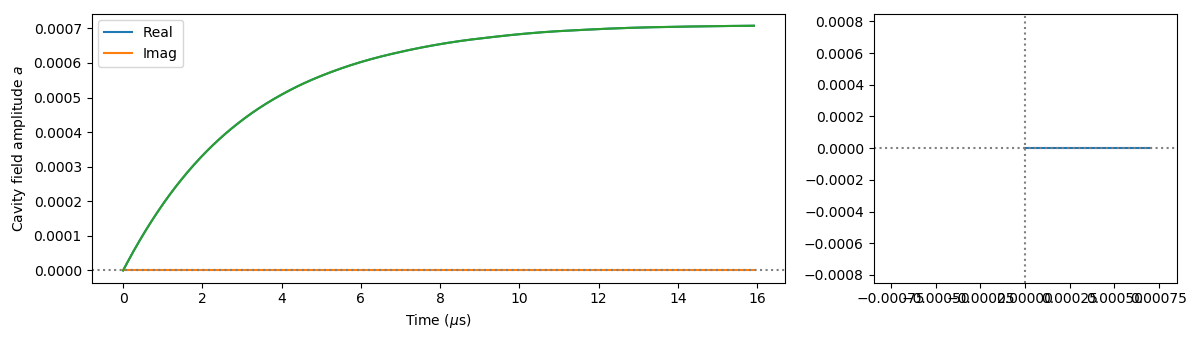

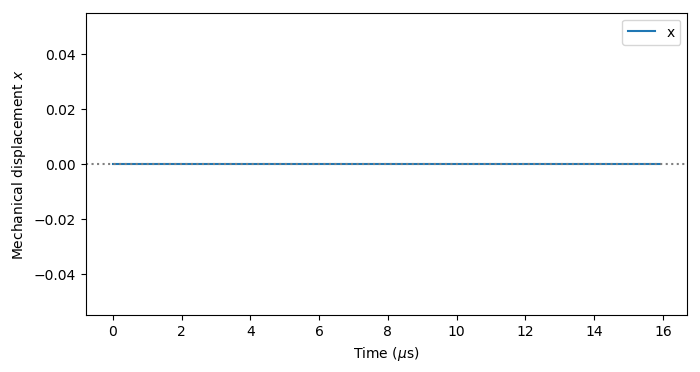

In [178]:
## Mechanics

gamma = 10e3 *2*pi # Hz * 2pi
m = 200e-12 *2*pi # kg
w_m = 200e3 *2*pi # Hz * 2pi

# Derived quantitites
x_zpf = np.sqrt(hbar/2/m/w_m)
print("x_zpf is %e m" % x_zpf)

## Coupling

g0 = 0 *2*pi # Hz * 2pi

# Derived Quantities
G = g0 / x_zpf

## Cavity

kappa = 100e3 * 2*pi # Hz * 2pi
kext = 50e3 # Hz * 2pi
delta = 0e5 * 2*pi# Hz * 2pi
probe = 1 # Power? 
w_probe = 0
pump = 0 # Power? 
w_pump = 0

# Initial conditions

x0 = 0
v0 = 0
a0 = 0+0j # Need this to be complex to force a complex-valued integrator
y0 = [x0, v0, a0]

# How long should we run simulation?
# Dynamnics for ringing up simulation will be on the order of 1/kappa

T = 10/kappa
t = np.linspace(0,T,1000)

sol = solve_ivp(dydt, [0,T], y0, t_eval=t, method='BDF')
x = sol.y[0]
v = sol.y[1]
a = sol.y[2]

plot_both()

## `g_0 = 0`, `delta != 0`, `w_probe != 0`, ring up cavity

In [174]:
def update1(pr = 0, d = 0):
    global delta, x, v, a, w_probe
    w_probe = pr*1e6 *2*pi
    delta = d*1e6 *2*pi
    sol = solve_ivp(dydt, [0,T], y0, t_eval=t, method='BDF')
    x = sol.y[0]
    v = sol.y[1]
    a = sol.y[2]
    plot_cavity()
    
interact(update1, pr=(-10,10,0.1), d=(-10,10,0.1))

interactive(children=(FloatSlider(value=0.0, description='pr', max=10.0, min=-10.0), FloatSlider(value=0.0, de…

<function __main__.update1(pr=0, d=0)>

## `g_0 = 20`, `delta != 0`, `w_probe != 0`, ring up cavity

In [185]:
g0 = 2* 2*pi # Hz
G = g0 / x_zpf
gamma = 10e3 *2*pi # Hz * 2pi
probe=100

T = 10/gamma
t = np.linspace(0,T,100000)

def update1(pr = 0, d = 0):
    global delta, x, v, a, w_probe
    w_probe = pr*1e6 *2*pi
    delta = d*1e6 *2*pi
    sol = solve_ivp(dydt, [0,T], y0, t_eval=t, method='BDF')
    x = sol.y[0]
    v = sol.y[1]
    a = sol.y[2]
    plot_both()
    
    
interact(update1, pr=(-10,10,0.1), d=(-10,10,0.1))

interactive(children=(FloatSlider(value=0.0, description='pr', max=10.0, min=-10.0), FloatSlider(value=0.0, de…

<function __main__.update1(pr=0, d=0)>